# **OFA Neural Architecture Search**

## **NOTES**

This notebook explores finding an optimal tiny neural network that can efficiently run on a microcontroller while meeting memory, latency, and energy constraints. 


**Once-for-All (OFA) Neural Architecture Search** is used, as described in the paper *Once-for-All: Train One Network and Specialize it for Efficient Deployment (arXiv:1908.09791)*.  

OFA reduces the cost of specializing neural network architectures for different devices by training a large super-network that encompasses all possible sub-networks within a design space. These sub-networks can be deployed directly without retraining.  


OFA introduces **accuracy and efficiency predictors**. Typically, assessing a sub-network's accuracy requires running inference on an entire validation set, which can take about a minute on ImageNet. Instead, OFA collects a large set of (architecture, accuracy) pairs and trains a regression model to predict accuracy during the search. This reduces evaluation time from one minute to under one second per sub-network. A similar approach applies to efficiency predictors, where evaluating latency is typically slow due to repeated forward passes of candidate networks.  


THE OFA supernetwork used is the **MCUNet framework** from *MCUNetV2: Memory-Efficient Patch-based Inference for Tiny Deep Learning (arXiv:2110.15352)*. MCUNet is a system-algorithm co-design framework for tiny deep learning on microcontrollers. 

MCUNetV2 is a family of efficiency neural networks tailored for resource-constrained microntrollers. It utilizes patch-based inference, receptive field redistribution and system-NN co-design and greatly improves the accuracy-efficiency tradeoff of MCUNetV1 

The training dataset used is the **Visual Wake  Words** dataset (https://arxiv.org/abs/1906.05721) 






STUFF TO EXPLORE: 
    MCUNetV3 supernetwork is worth exploring as well.
    
    ResNet50 supernetwork 
    
    Bunch of configs to test 
    
    Improve the accuracy predictor with a better network 
    
    Define more constraints like energy (have to research how it can be calculated)
    

## **Table of Contents**

In [1]:
#fill out later 

## **Set Up**

### **Downloading MCUNET files and VWW Dataset**

In [1]:
#I just downloaded on dropbox and unzipped into local directory 


# print("Cleanning up workspace ...")
# !rm -rf *
#1>/dev/null suppresses standard output, so only errors (if any) are shown.

print("Installing graphviz ...")
!pip install graphviz

print("Installing thop and onnx ...")
#thop (Torch-OpCounter) → Computes FLOPs and parameter counts for PyTorch models.
# onnx → Supports model conversion to the ONNX format for interoperability.
!pip install thop 1>/dev/null
!pip install onnx 1>/dev/null
# print("Downloading MCUNet codebase ...")
# !wget https://www.dropbox.com/s/3y2n2u3mfxczwcb/mcunetv2-dev-main.zip?dl=0 >/dev/null
# !unzip mcunetv2-dev-main.zip* 1>/dev/null
# !mv mcunetv2-dev-main/* . 1>/dev/null

# print("Downloading VWW dataset ...")
# !wget https://www.dropbox.com/s/169okcuuv64d4nn/data.zip?dl=0 >/dev/null

# print("Unzipping VWW dataset ...")
# !unzip data.zip* 1>/dev/null



Installing graphviz ...
Installing thop and onnx ...


### **Imports**

In [1]:
import argparse
import json
from PIL import Image
from tqdm import tqdm
import copy
import math
import numpy as np
import os
import random
import torch
from torch import nn
from torchvision import datasets, transforms
from mcunet.tinynas.search.accuracy_predictor import (
    AccuracyDataset,
    MCUNetArchEncoder,
)

from mcunet.tinynas.elastic_nn.networks.ofa_mcunets import OFAMCUNets
from mcunet.utils.mcunet_eval_helper import calib_bn, validate
from mcunet.utils.arch_visualization_helper import draw_arch
from mcunet.utils.pytorch_utils import count_peak_activation_size, count_net_flops, count_parameters


%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [13]:
import os

#switch to the correct directory 

# os.chdir('./mac')
# os.chdir('./Desktop')
# os.chdir('./Human Classification')


print("Current working directory:", os.getcwd())
print("\nContents of the directory:")
for item in os.listdir():
    print(item)

Current working directory: /Users/mac/Desktop/Human Classification/NAS

Contents of the directory:
test_model.py
acc_datasets
.DS_Store
generate_accuracy_dataset.py
LICENSE
requirements.txt
README.md
setup.py
eval_torch.py
OFA_NAS.ipynb
search.py
.ipynb_checkpoints
vww_supernet.pth
data
assets
eval_tflite.py
mcunet


In [7]:
#for m1 macbook
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

mps


## **VWW dataset Prep + Dataloader**

Let's first visualize some samples in the VWW dataset. This is a binary image classficiation (whether people is present in the image) dataset subsampled from [Microsoft COCO](https://arxiv.org/abs/1405.0312). We first define a function to set up a dataloader over the validation set.

Note: The function `build_val_data_loader` has an argument `split`. We use `split = 0` (default value) to represent the validation set (cannot be directly used for architecture search), and `split = 1` will be used as a holdout minival set (used to generate the accuracy dataset and calibrate BN parameters).

In [2]:
def build_val_data_loader(data_dir, resolution, batch_size=128, split=0):
    # split = 0: real val set, split = 1: holdout validation set
    assert split in [0, 1]
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    kwargs = {"num_workers": min(8, os.cpu_count()), "pin_memory": False}

    val_transform = transforms.Compose(
        [
            transforms.Resize(
                (resolution, resolution)
            ),  # if center crop, the person might be excluded
            transforms.ToTensor(),
            normalize,
        ]
    )
    val_dataset = datasets.ImageFolder(data_dir, transform=val_transform)

    val_dataset = torch.utils.data.Subset(
        val_dataset, list(range(len(val_dataset)))[split::2]
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, **kwargs
    )
    return val_loader

Using that dataloader builder, we are able to navigate through the VWW validation set. You can run the following cell for several times to see different images in the dataset.

In [3]:
data_dir = "data/vww-s256/val"

val_data_loader = build_val_data_loader(data_dir, resolution=128, batch_size=1)

# vis_x, vis_y = 2, 3
# fig, axs = plt.subplots(vis_x, vis_y)

# num_images = 0
# for data, label in val_data_loader:
#     img = np.array((((data + 1) / 2) * 255).numpy(), dtype=np.uint8)
#     img = img[0].transpose(1, 2, 0)
#     if label.item() == 0:
#         label_text = "No person"
#     else:
#         label_text = "Person"
#     axs[num_images // vis_y][num_images % vis_y].imshow(img)
#     axs[num_images // vis_y][num_images % vis_y].set_title(f"Label: {label_text}")
#     axs[num_images // vis_y][num_images % vis_y].set_xticks([])
#     axs[num_images // vis_y][num_images % vis_y].set_yticks([])
#     num_images += 1
#     if num_images > vis_x * vis_y - 1:
#         break

# plt.show()

In [4]:
print(val_data_loader)

Cool, now you have a basic idea about the dataset. Let's then construct the OFA super network! The `OFAMCUNets` super network is composed of $>10^{19}$ subnets in the MCUNetV2 design space. The subnets are composed of [inverted MobileNet blocks](https://arxiv.org/abs/1801.04381) with different kernel sizes (3, 5, 7) and expand ratios (3, 4, 6). The OFA super network also allows elastic depths (base depth to base_depth + 2) for all network stages. Finally, the super network supports global channel scaling (specified by `width_mult_list`) by 0.5$\times$, 0.75$\times$ or 1.0$\times$.

In [8]:
# device = "cuda:0"  # Use GPU (if available)
# device = 'cpu'
kernel_sizes = [3, 5, 7]
expand_ratios = [3, 4, 6]
depth_list = [0,1,2]

ofa_network = OFAMCUNets(
    n_classes=2,  # The number of output classes (for example, 2 classes for binary classification)
    bn_param=(0.1, 1e-3),  # Batch normalization settings (helps training stability)
    dropout_rate=0.0,  # No dropout (used to prevent overfitting)
    base_stage_width="mcunet384",  # Base width of the network
    width_mult_list=[0.5, 0.75, 1.0],  # Channel scaling options (adjusts model width)
    ks_list=kernel_sizes,  # Kernel sizes to choose from
    expand_ratio_list=expand_ratios,  # Different expand ratios
    depth_list=depth_list,  # Depth variations (allows different number of layers)
    base_depth=[1, 2, 2, 2, 2],  # Default depths for different layers
    fuse_blk1=True,  # Whether to fuse the first block (improves efficiency)
    se_stages=[False, [False, True, True, True], True, True, True, False],
    # Squeeze-and-excitation (SE) blocks, which help the model focus on important features
)


ofa_network.load_state_dict(
    torch.load("vww_supernet.pth", map_location="cpu")["state_dict"], strict=True
)

#torch.load("vww_supernet.pth") → Loads a saved model checkpoint from the file "vww_supernet.pth".
# In PyTorch, .pth files are used to save:
# Model weights (also known as parameters)
# Model architecture metadata
# Sometimes optimizer states and training history
# map_location="cpu" → Forces the model to be loaded onto the CPU, even if it was originally trained on a GPU.


ofa_network = ofa_network.to(device)

In [9]:
print(ofa_network)

OFAMCUNets(
  (first_conv): DynamicConvLayer(
    (conv): DynamicPointConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    )
    (bn): DynamicBatchNorm2d(
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): ReLU6(inplace=True)
  )
  (blocks): ModuleList(
    (0): MobileInvertedResidualBlock(
      (mobile_inverted_conv): DynamicMBConvLayer(
        (point_linear): Sequential(
          (conv): DynamicPointConv2d(
            (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          )
          (bn): DynamicBatchNorm2d(
            (bn): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )
    (1): MobileInvertedResidualBlock(
      (mobile_inverted_conv): DynamicMBConvLayer(
        (inverted_bottleneck): Sequential(
          (conv): DynamicPointConv2d(
            (conv): Conv2d(16, 96, kernel_size=(1, 1), stri

We then verify that the checkpoint is correctly loaded. We will sample some networks in the MCUNetV2 design space and evaluate its accuracy on the VWW dataset. The evaluation will take less than one minutes, and you are expected to see an accuracy around 83.6-88.7%. As you can see, we can directly extract these subnets from the design space and get their accuracy very quickly without **training**. This is a unique advantage brought by once-for-all (OFA) super networks.

Let's first define a helper function `evaluate_sub_network` that testes the accuracy of a sub network directly extracted from the super network.

In [10]:

def evaluate_sub_network(ofa_network, cfg, image_size=None):
    if "image_size" in cfg:
        image_size = cfg["image_size"]
    batch_size = 128
    # step 1. sample the active subnet with the given config.
    ofa_network.set_active_subnet(**cfg)
    # step 2. extract the subnet with corresponding weights.
    subnet = ofa_network.get_active_subnet().to(device)
    # step 3. calculate the efficiency stats of the subnet.
    peak_memory = count_peak_activation_size(subnet, (1, 3, image_size, image_size))
    macs = count_net_flops(subnet, (1, 3, image_size, image_size))
    params = count_parameters(subnet)
    # step 4. perform BN parameter re-calibration.
    calib_bn(subnet, data_dir, batch_size, image_size)
    # step 5. define the validation dataloader.
    val_loader = build_val_data_loader(data_dir, image_size, batch_size)
    # step 6. validate the accuracy.
    acc = validate(subnet, val_loader)
    return acc, peak_memory, macs, params

We also provide a handly helper function to visualize the architecture of the subnets. The function takes in the configuration of the subnet and returns an image representing the architecture.

In [9]:
def visualize_subnet(cfg):
    draw_arch(cfg["ks"], cfg["e"], cfg["d"], cfg["image_size"], out_name="viz/subnet")
    im = Image.open("viz/subnet.png")
    im = im.rotate(90, expand=1)
    fig = plt.figure(figsize=(im.size[0] / 250, im.size[1] / 250))
    plt.axis("off")
    plt.imshow(im)
    plt.show()

Now, let's visualize some subnets and evaluate them on the VWW dataset! We provide an example to randomly sample a subnet from the design space, and get its accuracy, macs, parameters on the VWW dataset. We also visualize the architecture using `visualize_subnet`.

In the architecture visualization, the legend of each block `MBConv{e}-{k}x{k}` means that the current block is a mobile inverted block with expand ratio `e` and the kernel size of the depthwise convolution layer is `k`. Different colors of the blocks indicate different kernel sizes, and gray blocks are network stage dividers. Different widths for the blocks indicate different expand ratios. We also annotate the output resolution close to each block.

Note that we assume that the image resolution is fixed to be 96. Feel free to add another cell below and play with the input resolution.

Hint: you can change the `sample_function` argument of the `sample_active_subnet` method to control the sampling process.

In [8]:
image_size = 96

cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
# acc, _, _, params = evaluate_sub_network(ofa_network, cfg)
# # visualize_subnet(cfg)
# print(f"The accuracy of the sampled subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

# largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
# acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
# # visualize_subnet(largest_cfg)
# print(f"The largest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

# smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
# acc, peak_memory, macs, params = evaluate_sub_network(ofa_network, smallest_cfg)
# # visualize_subnet(smallest_cfg)
# print(f"The smallest subnet: #params={params/1e6: .1f}M, accuracy={acc: .1f}%.")

{'wid': 1, 'ks': [5, 7, 7, 5, 3, 7, 7, 5, 3, 7, 3, 5, 5, 3, 7, 5, 5, 3, 5, 7], 'e': [3, 6, 4, 6, 4, 3, 3, 3, 3, 4, 4, 3, 6, 3, 6, 3, 4, 4, 4, 6], 'd': [1, 0, 1, 0, 1, 2], 'image_size': 96}


In [11]:
cfg_test = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=96)
print(cfg_test)
 #sample_active_subnet returns a dictionary describing a specific sub-network.
ofa_network.set_active_subnet(**cfg_test)
subnet = ofa_network.get_active_subnet().to(device)
# print(a)

peak_memory = count_peak_activation_size(subnet, (1, 3, 96, 96))
print(peak_memory)
macs = count_net_flops(subnet, (1, 3, 96, 96))
print(macs)
params = count_parameters(subnet)
print(params)
    # # step 4. perform BN parameter re-calibration.
# calib_bn(subnet, data_dir, 1, 96)
print('hi')
    # # step 5. define the validation dataloader.
    # # step 6. validate the accuracy.
acc = validate(subnet, val_data_loader)

print(acc)

# {
#     'ks': [3, 5, 3, 5, 7, 3, 3],  # Kernel sizes per layer
#     'e': [3, 4, 6, 3, 3, 6, 4],   # Expansion ratios per layer
#     'd': [2, 3, 4, 2, 2, 3, 4],   # Depths (number of layers per block)
#     'image_size': 96              # Input image resolution
# }


{'wid': 0, 'ks': [7, 7, 7, 7, 7, 5, 7, 7, 5, 7, 3, 7, 7, 7, 7, 7, 5, 5, 7, 3], 'e': [6, 3, 3, 6, 6, 3, 4, 3, 3, 3, 6, 6, 4, 3, 4, 6, 3, 6, 6, 6], 'd': [2, 2, 0, 1, 2, 2], 'image_size': 96}
138240.0
26691744.0
863994
hi


Validate:   0%|                                        | 0/4030 [00:49<?, ?it/s]


AssertionError: Torch not compiled with CUDA enabled


=== Evaluating Subnets at Image Size: 96x96 ===



Validate: 100%|██████████| 32/32 [00:08<00:00,  3.80it/s, loss=0.29, top1=88.6]


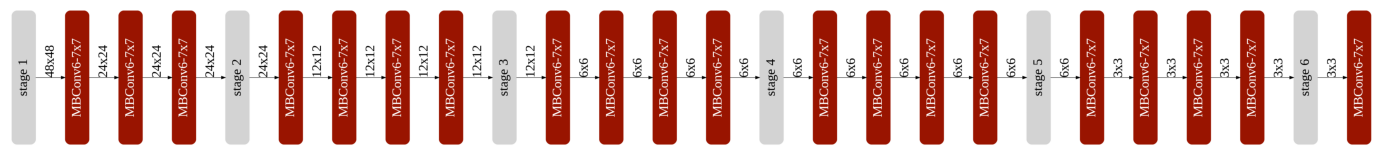

The custom subnet (large kernels, limited depth): #params=2.5M, accuracy=88.6%.

=== Evaluating Subnets at Image Size: 128x128 ===



Validate: 100%|██████████| 32/32 [00:08<00:00,  3.78it/s, loss=0.21, top1=92.3]


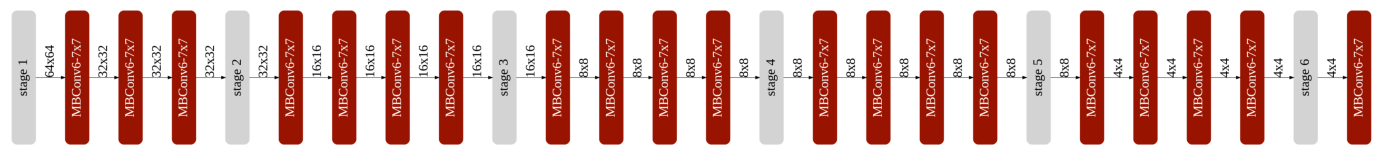

The custom subnet (large kernels, limited depth): #params=2.5M, accuracy=92.3%.

=== Evaluating Subnets at Image Size: 160x160 ===



Validate: 100%|██████████| 32/32 [00:10<00:00,  2.92it/s, loss=0.183, top1=93.9]


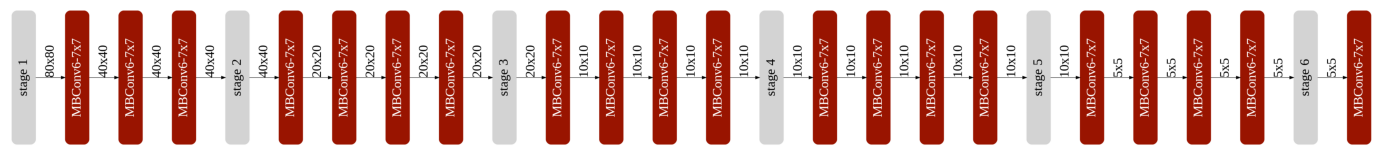

The custom subnet (large kernels, limited depth): #params=2.5M, accuracy=93.9%.


In [ ]:
import random

# Experiment with different image sizes
image_sizes = [96, 128, 160]  # Try different input resolutions

for image_size in image_sizes:
    print(f"\n=== Evaluating Subnets at Image Size: {image_size}x{image_size} ===\n")

    # # Sample a random subnet
    # sampled_cfg = ofa_network.sample_active_subnet(sample_function=random.choice, image_size=image_size)
    # acc, _, _, params = evaluate_sub_network(ofa_network, sampled_cfg)
    # visualize_subnet(sampled_cfg)
    # print(f"The accuracy of the sampled subnet: #params={params/1e6:.1f}M, accuracy={acc:.1f}%.")

    # # Largest subnet
    # largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
    # acc, _, _, params = evaluate_sub_network(ofa_network, largest_cfg)
    # visualize_subnet(largest_cfg)
    # print(f"The largest subnet: #params={params/1e6:.1f}M, accuracy={acc:.1f}%.")

    # # Smallest subnet
    # smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
    # acc, _, _, params = evaluate_sub_network(ofa_network, smallest_cfg)
    # visualize_subnet(smallest_cfg)
    # print(f"The smallest subnet: #params={params/1e6:.1f}M, accuracy={acc:.1f}%.")

    # Custom subnet: Prioritizing larger kernels but limiting depth
    def custom_sample_function(options):
        return max(options)  # Prioritize larger kernels, limit depth




    custom_cfg = ofa_network.sample_active_subnet(sample_function=custom_sample_function, image_size=image_size)
    acc, _, _, params = evaluate_sub_network(ofa_network, custom_cfg)
    visualize_subnet(custom_cfg)
    print(f"The custom subnet (large kernels, limited depth): #params={params/1e6:.1f}M, accuracy={acc:.1f}%.")


Validate: 100%|██████████| 32/32 [00:07<00:00,  4.31it/s, loss=0.338, top1=85.8]


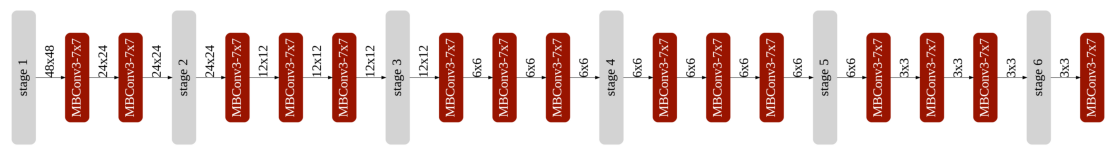

The custom subnet (large kernels, limited depth): #params=0.5M, accuracy=85.8%.


In [ ]:
def max_kernel_min_depth(options):
  if options == kernel_sizes:
      return max(options)
  if options == expand_ratios:
    return min(options)

  return options[0] #default case

custom_cfg = ofa_network.sample_active_subnet(sample_function=max_kernel_min_depth, image_size=96)
acc, _, _, params = evaluate_sub_network(ofa_network, custom_cfg)
visualize_subnet(custom_cfg)
print(f"The custom subnet (large kernels, limited depth): #params={params/1e6:.1f}M, accuracy={acc:.1f}%.")

### Question 1 (5 pts): Design space exploration.

Try manually sample different subnets by running the cell above multiple times. You can also vary the input resolution. Talk about your findings.

Hint: which dimension plays the most important role for the accuracy?

**Answer:**

Larger models perform slightly better but may not justify the increase in compute cost.
Kernel size and depth matter:
Larger kernel sizes (e.g.,
7
x
7
7x7) capture more spatial features.
Expansion ratio also affects performance.
Smallest subnet has a big accuracy drop, meaning reducing model size too much hurts accuracy.

## **Part 1. Predictors (3 Questions, 30 pts)**

Neural architecture search requires sampling a large amount of sub-networks from the OFA supernet and evaluate the performance of these sub-networks. Such performance evaluation is time-consuming.


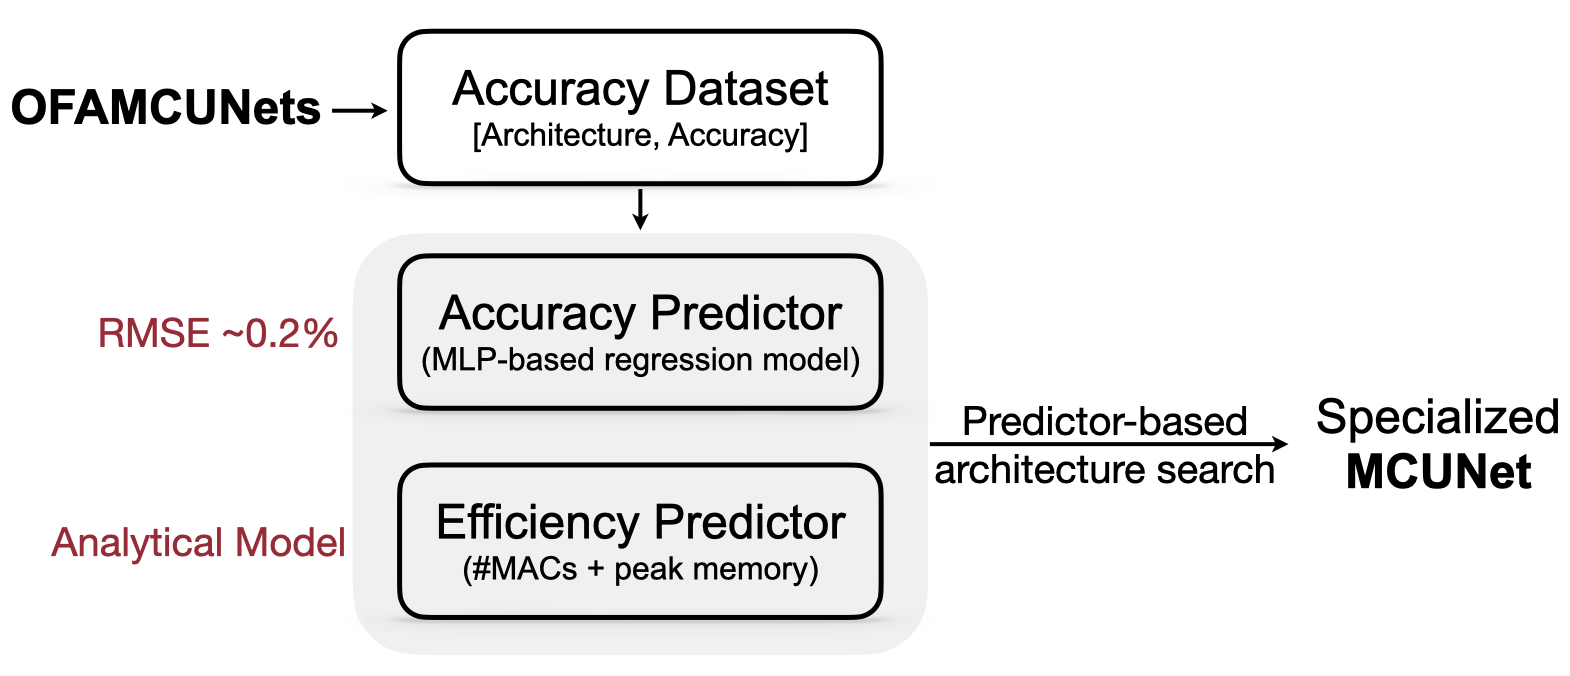

In this lab, we explore very fast neural network search with **efficiency predictors** and **accuracy predictors**.

### Question 2 (10 pts): Implement the efficiency predictor.

For the efficiency predictor, we use an hook-based analytical model to count the #MACs and peak memory consumption of a given network. Let's build it from scratch using our provided APIs.

Specifically, we define a class called `AnalyticalEfficiencyPredictor`. There are two major functions in this class, `get_efficiency` and `satisfy_constraint`.

The function `get_efficiency` takes in the subnet configuration and returns the #MACs and peak memory of the given subnet. Here, we assume the unit for the #MACs is million and the unit of the peak memory consumption is KB.

Hint: take a look at the `evaluate_sub_network` function above. Let's use `count_net_flops` to get the MACs of the network and `count_peak_activation_size` to get the activation size of the network.


In [ ]:
class AnalyticalEfficiencyPredictor:
    def __init__(self, net):
        self.net = net

    def get_efficiency(self, spec: dict):
        self.net.set_active_subnet(**spec)
        subnet = self.net.get_active_subnet()
        if torch.cuda.is_available():
            subnet = subnet.cuda()
        ############### YOUR CODE STARTS HERE ###############
        # Hint: take a look at the `evaluate_sub_network` function above.
        # Hint: the data shape is (batch_size, input_channel, image_size, image_size)

        batch_size = 1 #  efficiency is measured for processing a single image at a time.
        input_channel = 3
        image_size = spec['image_size'] # Extract input channels
        data_shape = (batch_size, input_channel, image_size, image_size)

        macs = count_net_flops(subnet, data_shape)  # Compute MACs
        peak_memory = count_peak_activation_size(subnet, data_shape)  # Compute peak memory in bytes

        ################ YOUR CODE ENDS HERE ################

        return dict(millionMACs=macs / 1e6, KBPeakMemory=peak_memory / 1024)

    def satisfy_constraint(self, measured: dict, target: dict):
        for key in measured:
            # if the constraint is not specified, we just continue
            if key not in target:
                continue
            # if we exceed the constraint, just return false.
            if measured[key] > target[key]:
                return False
        # no constraint violated, return true.
        return True

Let's test your implementation for the analytical efficiency predictor by examining the returned values for the smallest and largest subnets we just evaluated a while ago. The results from the efficiency predictor should match with the previous results.

In [ ]:
efficiency_predictor = AnalyticalEfficiencyPredictor(ofa_network)

image_size = 96
# Print out the efficiency of the smallest subnet.
smallest_cfg = ofa_network.sample_active_subnet(sample_function=min, image_size=image_size)
eff_smallest = efficiency_predictor.get_efficiency(smallest_cfg)

# Print out the efficiency of the largest subnet.
largest_cfg = ofa_network.sample_active_subnet(sample_function=max, image_size=image_size)
eff_largest = efficiency_predictor.get_efficiency(largest_cfg)

print("Efficiency stats of the smallest subnet:", eff_smallest)
print("Efficiency stats of the largest subnet:", eff_largest)

Efficiency stats of the smallest subnet: {'millionMACs': 8.302128, 'KBPeakMemory': 72.0}
Efficiency stats of the largest subnet: {'millionMACs': 79.416432, 'KBPeakMemory': 270.0}


### Question 3 (10 pts): Implement the accuracy predictor.

For the accuracy predictor, it predicts the classification accuracy of a given sub-network on the VWW dataset so that we do **NOT** need to run costly inference every time when we encounter a new subnet during architecture search. Such an accuracy predictor is an MLP (multi-layer perception) model trained on an accuracy dataset built with the OFA network. The inference of an MLP network takes only a few milliseconds, thus the accuracy predictor can speedup the search process by **orders of magnitude**.

The accuracy predictor takes in the architecture of a sub-network and predicts its accuracy on the VWW dataset. Since it is an MLP network, the sub-network must be encoded into a **vector**. In this lab, we provide a class `MCUNetArchEncoder` to perform such conversion from **sub-network architecture** to a **binary vector**.

In [ ]:
image_size_list = [96, 112, 128, 144, 160]


# architecture encoder (MCUNetArchEncoder).
#  The purpose of this encoder is to convert a sub-network's architecture (its structural parameters)
#  into a binary vector so that an MLP (Multi-Layer Perceptron) model can process it for accuracy prediction.

arch_encoder = MCUNetArchEncoder(
    image_size_list=image_size_list,
    base_depth=ofa_network.base_depth,
    depth_list=ofa_network.depth_list,
    expand_list=ofa_network.expand_ratio_list,
    width_mult_list=ofa_network.width_mult_list,
)

In [ ]:
print(arch_encoder)
print(arch_encoder.n_dim)

128


We generated an accuracy dataset beforehand, which is a collection of `[architecture, accuracy]` pairs stored under the `acc_datasets` folder.

With the architecture encoder, you are now required define the accuracy predictor, which is a multi-layer perception (MLP) network with 400 channels per intermediate layer. For simplicity, we fix the number of layers to be **3**. Please implement this MLP network in the following cell.

**Input**: A numerical vector from MCUNetArchEncoder that represents the sub-network architecture.

**Output**: A single scalar value representing the predicted accuracy.

**Structure**: A 3-layer MLP with 400 hidden units per layer and ReLU activations.

In [ ]:
class AccuracyPredictor(nn.Module):
    def __init__(self, arch_encoder, hidden_size=400, n_layers=3, checkpoint_path=None, device="cuda:0"):
        super(AccuracyPredictor, self).__init__()
        self.arch_encoder = arch_encoder
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        layers = []

        ############### YOUR CODE STARTS HERE ###############
        # Let's build an MLP with n_layers layers.
        # Each layer (nn.Linear) has hidden_size channels and
        # uses nn.ReLU as the activation function.
        # Hint: You can assume that n_layers is fixed to be 3, for simplicity.
        # Hint: the input dimension of the first layer is not hidden_size.
        #       use self.arch_encoder.n_dim to get the input dimension


        for i in range(self.n_layers):
          layers.append( nn.Linear(self.arch_encoder.n_dim, self.hidden_size) if i == 0 else nn.Linear(self.hidden_size, self.hidden_size) )

        #Input layer
        # layers.append(nn.Linear(self.arch_encoder.n_dim, self.hidden_size))
        # layers.append(nn.ReLU())

        # # Hidden layers: all of them have the same input and output size (hidden_size)
        # for _ in range(self.n_layers - 1):  # We already added the first layer, so loop (n_layers - 1) times
        #     layers.append(nn.Linear(self.hidden_size, self.hidden_size))
        #     layers.append(nn.ReLU())


        ################ YOUR CODE ENDS HERE ################

        # Final output layer: single neuron output for accuracy prediction
        layers.append(nn.Linear(self.hidden_size, 1, bias=False))
        self.layers = nn.Sequential(*layers)
        self.base_acc = nn.Parameter(
            torch.zeros(1, device=self.device), requires_grad=False
        )

        if checkpoint_path is not None and os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location="cpu")
            if "state_dict" in checkpoint:
                checkpoint = checkpoint["state_dict"]
            self.load_state_dict(checkpoint)
            print("Loaded checkpoint from %s" % checkpoint_path)

        self.layers = self.layers.to(self.device)

    def forward(self, x):
        y = self.layers(x).squeeze()
        return y + self.base_acc


    def predict_acc(self, arch_dict_list):
      """
      Predicts the accuracy of given neural network architectures.

      This function takes a list of architecture dictionaries, encodes them into
      feature vectors using `arch_encoder.arch2feature()`, and then passes them
      through the accuracy predictor model to obtain predicted accuracy values.

      Args:
          arch_dict_list (list of dict):
              A list of architecture configurations where each dictionary represents
              a specific neural network architecture. The dictionary structure should
              be compatible with `arch_encoder.arch2feature()`.

      Returns:
          torch.Tensor:
              A tensor containing the predicted accuracy values for each input architecture.
              The shape of the output tensor matches the number of architectures in `arch_dict_list`.

      Example:
          ```python
          arch_dicts = [
              {"image_size": 160, "depth": [2, 3, 4, 2], "expand_ratio": [3, 4, 6, 3], "width_mult": [0.75, 1.0, 1.25]},
              {"image_size": 192, "depth": [3, 4, 4, 3], "expand_ratio": [4, 6, 6, 4], "width_mult": [1.0, 1.25, 1.5]}
          ]

          predicted_accuracies = acc_predictor.predict_acc(arch_dicts)
          ```

      Notes:
          - Converts architecture configurations into numerical feature vectors.
          - Uses the model's forward pass to predict accuracy.
          - Moves input data to the specified device (`self.device`).
      """
      X = [self.arch_encoder.arch2feature(arch_dict) for arch_dict in arch_dict_list]
      X = torch.tensor(np.array(X)).float().to(self.device)
      return self.forward(X)


Let's print out the architecture of the `AccuracyPredictor` you just defined.

In [ ]:
os.makedirs("pretrained", exist_ok=True)

acc_pred_checkpoint_path = (
    f"pretrained/{ofa_network.__class__.__name__}_acc_predictor.pth"
)


acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    checkpoint_path=None,
    device='cpu', #my gpu is not available rn
)
print(acc_predictor)

AccuracyPredictor(
  (layers): Sequential(
    (0): Linear(in_features=128, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): Linear(in_features=400, out_features=1, bias=False)
  )
)


Let's first visualize some samples in the accuracy dataset in the following cell.

The accuracy dataset is composed of 50,000 `[architecture, accuracy]` pairs, where 40,000 of them are used as the training set and the rest 10,000 are used as validation set.

For **accuracy**, We calculate the average accuracy of all `[architecture, accuracy]` pairs on the accuracy dataset and define it as `base_acc`. For the accuracy predictor, instead of directly regressing the accuracy of each architecture, its training target is `accuracy - base_acc`. Since `accuracy - base_acc` is usually much smaller than `accuracy` itself, this can make training easier.

For **architecture**, each subnet within the design space is uniquely represented by a binary vector. The binary vector is a concatenation of the **one-hot representation** for both global parameters (*e.g.* input resolution, width multiplier) and parameters of each inverted MobileNet block (*e.g.* kernel sizes and expand ratios). Note that we prefer **one-hot** representations over **numerical** representations because all design hyperparameters are **discrete** values.

For example, our design space supports

```python
kernel_size = [3, 5, 7]
expand_ratio = [3, 4, 6]
```

Then, we represent `kernel_size=3` as `[1, 0, 0]`, `kernel_size=5` as `[0, 1, 0]`, and `kernel_size=7` as `[0, 0, 1]`. Similarly, for `expand_ratio=3`, it is written as `[1, 0, 0]`; `expand_ratio=4` is written as `[0, 1, 0]` and `expand_ratio=6` is written as `[0, 0, 1]`. The representation for each inverted MobileNet block is obtained by concatenating the kernel size embedding with the expand ratio embedding. Note that for skipped blocks, we use `[0, 0, 0]` to represent their kernel sizes and expand ratios. You will see a detailed explanation of the architecture-embedding correspondence after running the following cell.

Loading data: 100%|██████████| 50000/50000 [00:00<00:00, 68686.39it/s]


Train Size: 40000, Valid Size: 10000
The basic accuracy (mean accuracy of all subnets within the dataset is:  90.3%.
network embedding: [0 0 1 0 0 | 0 1 0 | 0 1 0 | 0 1 0 | 0 1 0 | 1 0 0 | 0 0 0 | 0 0 0 | 1 0 0 | 1 0 0 | 1 0 0 | 0 1 0 | 1 0 0 | 0 1 0 | 0 0 0 | 0 0 0 | 0 1 0 | 0 1 0 | 0 1 0 | 1 0 0 | 1 0 0 | 0 0 1 | 1 0 0 | 1 0 0 | 1 0 0 | 0 0 1 | 0 1 0 | 1 0 0 | 0 0 0 | 0 0 0 | 0 0 0 | 0 0 0 | 1 0 0 | 1 0 0 | 1 0 0 | 0 1 0 | 1 0 0 | 1 0 0 | 0 0 1 | 1 0 0 | 0 0 1 | 1 0 0]
image resolution embedding: [0 0 1 0 0] => image resolution: 128
width multiplier embedding: [0 1 0] => width multiplier: 0.75
**************************************************Stage1**************************************************
kernel size embedding: [0 1 0] => kernel size: 5; expand ratio embedding: [0 1 0] => expand ratio: 4
kernel size embedding: [0 1 0] => kernel size: 5; expand ratio embedding: [1 0 0] => expand ratio: 3
kernel size embedding: [0 0 0] expand ratio embedding: [0 0 0] => layer skipped.
*******

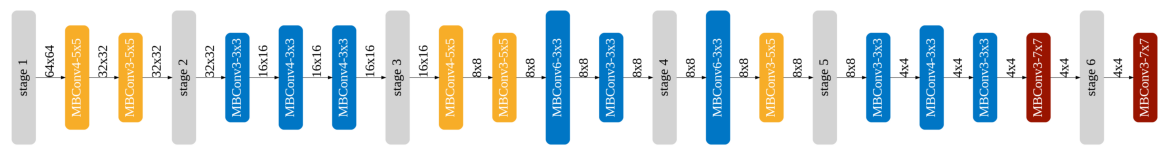

The accuracy of this subnet on the holdout validation set is:  91.1%.


In [ ]:
device = 'cpu'
acc_dataset = AccuracyDataset("acc_datasets")
train_loader, valid_loader, base_acc = acc_dataset.build_acc_data_loader(
    arch_encoder=arch_encoder
)

print(f"The basic accuracy (mean accuracy of all subnets within the dataset is: {(base_acc * 100): .1f}%.")

# Let's print one sample in the training set
sampled = 0
for (data, label) in train_loader:
    data = data.to(device)
    label = label.to(device)
    print("=" * 100)
    # dummy pass to print the divided encoding
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=False)
    # print out the architecture encoding process in detail
    arch_encoding = arch_encoder.feature2arch(data[0].int().cpu().numpy(), verbose=True)
    visualize_subnet(arch_encoding)
    print(f"The accuracy of this subnet on the holdout validation set is: {(label[0] * 100): .1f}%.")
    sampled += 1
    if sampled == 1:
        break


### Question 4 (10 pts): Complete the code for accuracy predictor training.


Now let's train the accuracy predictor using the dataset we provided! In this part, you are responsible for the implementation of the training and validation of your accuracy predictor. The training process will take roughly 1-2 minutes.

Hint: you may refer to Tutorial 2 on how to train a neural network with PyTorch.

In [2]:
# Initialize the accuracy predictor
acc_predictor = AccuracyPredictor(
    arch_encoder,
    hidden_size=400,
    n_layers=3,
    checkpoint_path=None,
    device=device,
)

NameError: name 'AccuracyPredictor' is not defined

In [ ]:


# Set base accuracy parameter
acc_predictor.base_acc = nn.Parameter(
    torch.zeros(1, device=acc_predictor.device), requires_grad=False
)
acc_predictor.base_acc.data += base_acc  # This is not ideal, but works.

# Move model to the specified device
acc_predictor.to(device)

# Define loss function and optimizer
criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(acc_predictor.parameters())

# Training loop
for epoch in tqdm(range(10)):
    acc_predictor.train()

    for (data, label) in tqdm(train_loader, desc=f"Epoch {epoch + 1}", position=0, leave=True):
        # Step 1: Move data and labels to the device
        data, label = data.to(device), label.to(device)

        ############### YOUR CODE STARTS HERE ###############
        # Step 2: Forward pass
        pred = acc_predictor(data)

        # Step 3: Compute loss
        loss = criterion(pred, label)

        # Step 4: Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ################ YOUR CODE ENDS HERE ################

    # Validation loop
    acc_predictor.eval()
    with torch.no_grad():
        with tqdm(total=len(valid_loader), desc="Validation", position=0, leave=True) as t:
            for (data, label) in valid_loader:
                # Step 1: Move data and labels to the device
                data, label = data.to(device), label.to(device)

                ############### YOUR CODE STARTS HERE ###############
                # Step 2: Forward pass
                pred = acc_predictor(data)

                # Step 3: Compute loss
                loss = criterion(pred, label)
                ############### YOUR CODE ENDS HERE ################

                t.set_postfix({"Loss": loss.item()})
                t.update(1)

# Save trained model checkpoint
if not os.path.exists(acc_pred_checkpoint_path):
    torch.save(acc_predictor.cpu().state_dict(), acc_pred_checkpoint_path)


#acc_predictor: This is the trained PyTorch model.
# .cpu(): Moves the model to the CPU (ensures compatibility across devices).
# .state_dict(): Retrieves the model’s parameters (weights & biases).
# torch.save(..., acc_pred_checkpoint_path): Saves the state dictionary to the specified path.

100%|██████████| 10/10 [00:53<00:00,  5.37s/it]


Now let's plot the correlation of predicted accuracy against ground truth accuracy and make sure our predictor is reliable. To receive full score, you are expected to see a linear correlation in this part.

Val:   0%|          | 0/40 [00:00<?, ?it/s]


Text(0.5, 1.0, 'Correlation between predicted accuracy and real accuracy')

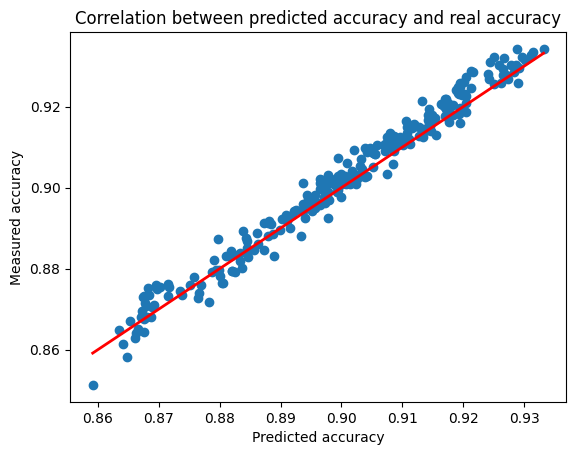

In [ ]:
predicted_accuracies = []
ground_truth_accuracies = []
# acc_predictor = acc_predictor.to("cuda:0")
acc_predictor = acc_predictor.to("cpu")

acc_predictor.eval()
with torch.no_grad():
    with tqdm(total=len(valid_loader), desc="Val") as t:
        for (data, label) in valid_loader:
            data = data.to(device)
            label = label.to(device)
            pred = acc_predictor(data)
            predicted_accuracies += pred.cpu().numpy().tolist()
            ground_truth_accuracies += label.cpu().numpy().tolist()
            if len(predicted_accuracies) > 200:
                break
plt.scatter(predicted_accuracies, ground_truth_accuracies)
# draw y = x
min_acc, max_acc = min(predicted_accuracies), max(predicted_accuracies)
plt.plot([min_acc, max_acc], [min_acc, max_acc], c="red", linewidth=2)
plt.xlabel("Predicted accuracy")
plt.ylabel("Measured accuracy")
plt.title("Correlation between predicted accuracy and real accuracy")

## **Part 2. Neural Architecture Search (6 Questions, 65 pts + 10 bonus pts)**



So far, we have defined both the efficiency and accuracy predictors. Let's start fast model specialization with these two powerful predictors!

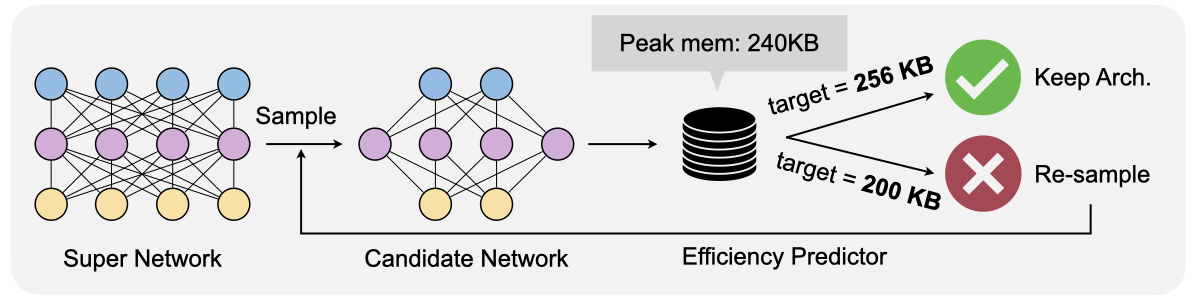

In this part, you are required to implement two typical search algorithms: **random search** and **evolutionary search**. The search algorithm aims to find the model architecture that provides the best accuracy while satisfying the efficiency constraints (e.g., MACs, peak memory).

In [ ]:
print(arch_encoder.random_sample_arch())

{'ks': [7, 3, 3, 5, 3, 3, 7, 5, 7, 7, 5, 3, 7, 3, 5, 5, 5, 7, 3, 7], 'e': [3, 4, 3, 3, 3, 3, 4, 6, 4, 3, 4, 3, 4, 3, 4, 6, 4, 6, 3, 6], 'd': [2, 1, 1, 1, 2, 2], 'image_size': 144, 'wid': 0}


### Question 5 (5 pts): Complete the following random search agent.

In [ ]:
class RandomSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint
        while True:
          #randomly samples an architecture from the possible architectures defined by MCUNetArchEncoder.
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def run_search(self, constraint, n_subnets=100):
        subnet_pool = []
        # sample subnets
        for _ in tqdm(range(n_subnets)):
            sample, efficiency = self.random_valid_sample(constraint)
            subnet_pool.append(sample)
        # predict the accuracy of subnets
        accs = self.accuracy_predictor.predict_acc(subnet_pool) # Returns a tensor containing the predicted accuracy values for each input architecture.
        ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        # get the index of the best subnet
        best_idx = torch.argmax(accs.flatten())
        ############### YOUR CODE ENDS HERE #################
        # return the best subnet
        return accs[best_idx], subnet_pool[best_idx]

### Question 6 (5 pts): Complete the following function.

In [ ]:
def search_and_measure_acc(agent, constraint, **kwargs):
    ############### YOUR CODE STARTS HERE ###############
    # hint: call the search function
    best_info = agent.run_search(constraint, **kwargs)
    ############### YOUR CODE ENDS HERE #################
    # get searched subnet
    ofa_network.set_active_subnet(**best_info[1])
    subnet = ofa_network.get_active_subnet().to(device)
    # calibrate bn
    calib_bn(subnet, data_dir, 128, best_info[1]["image_size"])
    # build val loader
    val_loader = build_val_data_loader(data_dir, best_info[1]["image_size"], 128)
    # measure accuracy
    acc = validate(subnet, val_loader)
    # print best_info
    print(f"Accuracy of the selected subnet: {acc}")
    # visualize model architecture
    visualize_subnet(best_info[1])
    return acc, subnet


In [ ]:
random.seed(1)
np.random.seed(1)


nas_agent = RandomSearcher(efficiency_predictor, acc_predictor)
# MACs-constrained search
subnets_rs_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millonMACs=millonMACs)
    print(f"Random search with constraint: MACs <= {millonMACs}M")
    subnets_rs_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)

# memory-constrained search
subnets_rs_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Random search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_rs_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint, n_subnets=300)


Random search with constraint: MACs <= 50M


Validate:   0%|          | 0/32 [00:02<?, ?it/s]


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Question7 (20 pts): Complete the following evolutionary search agent.



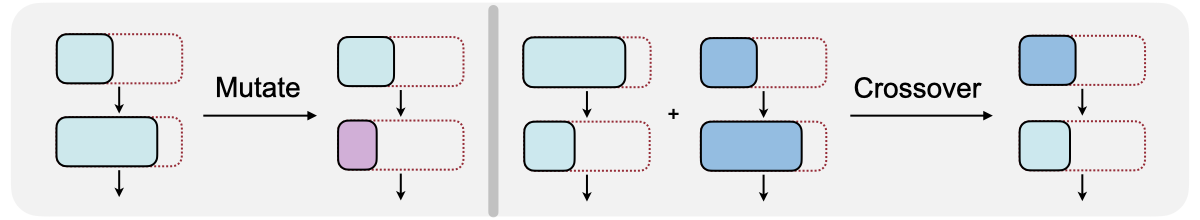

Now you have succesfully implemented the random search algorithm. In this part, we will implement a more sample-efficient search algorithm, evolutionary search. Evolutionary search is inspired by the evolution algorithm (or genetic algorithm). A **population** of sub-networks are first sampled from the design space. Then, in each **generation**, we perform random mutation and crossover operations as is shown in the figure above. The sub-networks with highest accuracy will be kept, and this process will be repeated until the number of generations reaches `max_time_budget`. Similar to the random search, throughout the search process, all sub-networks that cannot satisfy the efficiency constraint will be discarded.


In [ ]:
class EvolutionSearcher:
    def __init__(self, efficiency_predictor, accuracy_predictor, **kwargs):
        self.efficiency_predictor = efficiency_predictor
        self.accuracy_predictor = accuracy_predictor

        # evolution hyper-parameters
        self.arch_mutate_prob = kwargs.get("arch_mutate_prob", 0.1)
        self.resolution_mutate_prob = kwargs.get("resolution_mutate_prob", 0.5)
        self.population_size = kwargs.get("population_size", 100)
        self.max_time_budget = kwargs.get("max_time_budget", 500)
        self.parent_ratio = kwargs.get("parent_ratio", 0.25)
        self.mutation_ratio = kwargs.get("mutation_ratio", 0.5)

    def update_hyper_params(self, new_param_dict):
        #Allows modifying hyperparameters dynamically.
        self.__dict__.update(new_param_dict)

    def random_valid_sample(self, constraint):
        # randomly sample subnets until finding one that satisfies the constraint
        while True:
            sample = self.accuracy_predictor.arch_encoder.random_sample_arch()
            efficiency = self.efficiency_predictor.get_efficiency(sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return sample, efficiency

    def mutate_sample(self, sample, constraint):
        while True:
            new_sample = copy.deepcopy(sample)

            self.accuracy_predictor.arch_encoder.mutate_resolution(new_sample, self.resolution_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_width(new_sample, self.arch_mutate_prob)
            self.accuracy_predictor.arch_encoder.mutate_arch(new_sample, self.arch_mutate_prob)

            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency

    def crossover_sample(self, sample1, sample2, constraint):
        while True:
            new_sample = copy.deepcopy(sample1)
            for key in new_sample.keys():
                if not isinstance(new_sample[key], list):

                    #If a parameter (e.g., number of layers) is not a list, choose randomly between the values from sample1 or sample2.
                    new_sample[key] = random.choice([sample1[key], sample2[key]])

                else:
                    #If a parameter is a list (e.g., layer configurations), each element is randomly selected from either sample1 or sample2.
                    for i in range(len(new_sample[key])):
                        new_sample[key][i] = random.choice([ sample1[key][i], sample2[key][i] ])


            efficiency = self.efficiency_predictor.get_efficiency(new_sample)
            if self.efficiency_predictor.satisfy_constraint(efficiency, constraint):
                return new_sample, efficiency



    def run_search(self, constraint, **kwargs):
        self.update_hyper_params(kwargs)


        # Calculates the number of:
          # Mutations (mutation_ratio * population_size).
          # Parents to keep (parent_ratio * population_size).
        mutation_numbers = int(round(self.mutation_ratio * self.population_size))
        parents_size = int(round(self.parent_ratio * self.population_size))

        best_valids = [-100] #stores best accuracy values found
        population = []  # (acc, sample) tuples, stores best arc candidates
        child_pool = [] #stores the new generated arcs
        best_info = None

        # generate random population
        for _ in range(self.population_size):
            sample, efficiency = self.random_valid_sample(constraint)
            child_pool.append(sample)

        accs = self.accuracy_predictor.predict_acc(child_pool)
        for i in range(self.population_size):
            population.append((accs[i].item(), child_pool[i]))

        # evolving the population
        with tqdm(total=self.max_time_budget) as t:
            for i in range(self.max_time_budget):
                ############### YOUR CODE STARTS HERE ###############
                # hint: sort the population according to the acc (descending order)
                population = sorted(population, key=lambda x: x[0], reverse=True)

                ############### YOUR CODE ENDS HERE #################

                ############### YOUR CODE STARTS HERE ###############
                # hint: keep topK samples in the population, K = parents_size
                # the others are discarded.
                population = population[:parents_size]
                ############### YOUR CODE ENDS HERE #################

                # update best info
                acc = population[0][0]
                if acc > best_valids[-1]:
                    best_valids.append(acc)
                    best_info = population[0]
                else:
                    best_valids.append(best_valids[-1])

                child_pool = []
                for j in range(mutation_numbers):
                    # randomly choose a sample
                    par_sample = population[np.random.randint(parents_size)][1]
                    # mutate this sample
                    new_sample, efficiency = self.mutate_sample(par_sample, constraint)
                    child_pool.append(new_sample)

                for j in range(self.population_size - mutation_numbers):
                    # randomly choose two samples
                    par_sample1 = population[np.random.randint(parents_size)][1]
                    par_sample2 = population[np.random.randint(parents_size)][1]
                    # crossover
                    new_sample, efficiency = self.crossover_sample(
                        par_sample1, par_sample2, constraint
                    )
                    child_pool.append(new_sample)
                # predict accuracy with the accuracy predictor
                accs = self.accuracy_predictor.predict_acc(child_pool)
                for j in range(self.population_size):
                    population.append((accs[j].item(), child_pool[j]))

                t.update(1)

        return best_info

### Question 8 (10pts): Run evolutionary search and tune evo_params to optimize the results. Describe your findings.


In [ ]:
random.seed(1)
np.random.seed(1)

# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)
# MACs-constrained search
subnets_evo_macs = {}
for millonMACs in [50, 100]:
    search_constraint = dict(millionMACs=millonMACs)
    print(f"Evolutionary search with constraint: MACs <= {millonMACs}M")
    subnets_evo_macs[millonMACs] = search_and_measure_acc(nas_agent, search_constraint)

# memory-constrained search
subnets_evo_memory = {}
for KBPeakMemory in [256, 512]:
    search_constraint = dict(KBPeakMemory=KBPeakMemory)
    print(f"Evolutionary search with constraint: Peak memory <= {KBPeakMemory}KB")
    subnets_evo_memory[KBPeakMemory] = search_and_measure_acc(nas_agent, search_constraint)


### Question 9 (15 pts + 10 pts bonus): Run evolutionary search under real-world constraints.

In real-world applications, we may have multiple efficiency constraints: https://blog.tensorflow.org/2019/10/visual-wake-words-with-tensorflow-lite_30.html.
Use evolutionary search to find models that satisfy the following constraints:
- [15 pts] 250 KB, 60M MACs (acc >= 92.5% to get the full credit)
- [10 pts, **bonus**] 200KB, 30M MACs (acc >= 90% to get the full credit)

Hint: You do not have to use the same `evo_params` for these two tasks.

In [ ]:
random.seed(1)
np.random.seed(1)
# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [60, 250]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

In [ ]:
random.seed(1)
np.random.seed(1)
# hint: tune hyper-parameters below
evo_params = {
    'arch_mutate_prob': 0.1, # The probability of architecture mutation in evolutionary search
    'resolution_mutate_prob': 0.1, # The probability of resolution mutation in evolutionary search
    'population_size': 10,  # The size of the population
    'max_time_budget': 10,
    'parent_ratio': 0.1,
    'mutation_ratio': 0.1,
}

nas_agent = EvolutionSearcher(efficiency_predictor, acc_predictor, **evo_params)

(millionMACs, KBPeakMemory) = [30, 200]
print(f"Evolution search with constraint: MACs <= {millionMACs}M, peak memory <= {KBPeakMemory}KB")
search_and_measure_acc(nas_agent, dict(millionMACs=millionMACs, KBPeakMemory=KBPeakMemory))
print("Evolution search finished!")

### Question 10 (10 pts): Is it possible to find a subnet with the following efficiency constraints in the current design space?
- A: The activation size of the subnet is **at most 256KB** and the MACs of the subnet is **at most 15M**.
- B: The activation size of the subnet is **at most 64 KB**.
